**DS203 Project**

**Determining Factors Affecting Mental Health** 

By-

1.   Priyanka Bagade (18D070021)
2.   Rikin Shah (18D170028)
3.   Yash Gadhia (180100130)





*   Dataset Used - National Health and Nutrition Examination Survey 2017-18 
*   Offered by - Centers for Disease Control and Prevention (CDC)
*   Region - USA




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import jarque_bera

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
path = glob.glob("/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/*.XPT")
print(len(path))
print(path)

14
['/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/DEMO_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/DPQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/PFQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/DLQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/MCQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/SLQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/HUQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/PAQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/DBQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/OCQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/BMX_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/SMQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/DUQ_J.XPT', '/content/drive/MyDrive/Colab_Notebooks/DS203/Project/Data/RHQ_J.XPT']


In [ ]:
#setting initial dataframe
df = pd.read_sas(path[0], format = 'xport')

In [ ]:
#merge the rest of XPT files
for p in path[1:]: 
    s_df = pd.read_sas(p, format = 'xport')
    df = df.merge(s_df, on='SEQN', how = 'outer')

In [ ]:
df.sample(3)

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,...,RHQ070,RHQ074,RHQ076,RHQ078,RHQ131,RHD143,RHQ160,RHQ162,RHQ163,RHQ166,RHQ169,RHQ172,RHD173,RHQ171,RHD180,RHD190,RHQ197,RHQ200,RHD280,RHQ291,RHQ305,RHQ332,RHQ420,RHQ540,RHQ542A,RHQ542B,RHQ542C,RHQ542D,RHQ554,RHQ560Q,RHQ560U,RHQ570,RHQ576Q,RHQ576U,RHQ580,RHQ586Q,RHQ586U,RHQ596,RHQ602Q,RHQ602U
1318,95021.0,10.0,2.0,2.0,5.0,NaN,3.0,3.0,2.0,63.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,5.0,5.0,3.0,5.397605e-79,5.397605e-79,2.0,2.0,3.0,1.0,3.0,37122.541742,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5446,99149.0,10.0,2.0,2.0,3.0,NaN,3.0,3.0,1.0,40.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,7.0,7.0,1.0,1.000000e+00,1.000000e+00,1.0,3.0,2.0,1.0,2.0,13692.157796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
965,94668.0,10.0,2.0,1.0,7.0,NaN,3.0,3.0,2.0,92.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,6.0,6.0,2.0,2.000000e+00,5.397605e-79,2.0,2.0,3.0,1.0,3.0,17926.639051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Determining a Mental Health Index (MHI) based on Depression Screener Questions. 

In [ ]:
# select only depression screener columns and subject number
cols = ['SEQN'] + [c for c in df.columns if c.startswith('DPQ')]
DPQ = df.loc[:, cols]
DPQ.SEQN = DPQ.SEQN.apply(lambda x: str(x))

In [ ]:
DPQ.describe() # it seems like 0 didn't get converted properly

,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
count,5.094000e+03,5.093000e+03,5.093000e+03,5.092000e+03,5.092000e+03,5.091000e+03,5.091000e+03,5.091000e+03,5.090000e+03,3.362000e+03
mean,3.992933e-01,3.593167e-01,6.465737e-01,7.617832e-01,3.994501e-01,2.567276e-01,2.722451e-01,1.791397e-01,6.149312e-02,3.277811e-01
std,8.201561e-01,7.668570e-01,9.911066e-01,9.754442e-01,8.171601e-01,7.001904e-01,7.219092e-01,6.272503e-01,3.969209e-01,6.428110e-01
min,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
25%,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
50%,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
75%,1.000000e+00,5.397605e-79,1.000000e+00,1.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.000000e+00
max,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00


In [ ]:
# all of these should be integers
for c in DPQ.columns[1:]:
    DPQ[c] = DPQ[c].apply(lambda x: np.nan if math.isnan(x) else int(x))

In [ ]:
DPQ = DPQ.replace(7, np.nan)
DPQ = DPQ.replace(9, np.nan)

In [ ]:
# If DPQ100 is missing, replace it with 0.
DPQ.DPQ100 = DPQ.DPQ100.replace(np.nan, 0)

In [ ]:
# If there are more than half columns missing, drop the subject.
DPQ = DPQ.drop(DPQ[DPQ.isnull().sum(axis = 1) > 4].index, axis = 0)

In [ ]:
# select the value that correlates the most with each columns
tmp = DPQ.dropna().iloc[:, 1:10]
cols = list(DPQ.columns)[1:10]
cor_dict = {}
for c in cols: 
    Y = tmp[c]
    X = tmp.drop(c, axis = 1)
    corr_ = X.corrwith(Y)
    max_ = corr_[corr_ == max(corr_)]
    cor_dict[c] = (list(max_.index)[0], max_[0])

In [ ]:
# fill NA with the value from highest correlated questionnarie
for k, v in cor_dict.items():
    DPQ[k] = DPQ[k].fillna(DPQ[v[0]])

In [ ]:
# there are a few that could not be filled (probably because both variables were empty). 
# There aren't that many so I'll drop these ones.
DPQ = DPQ.dropna(axis = 0)

In [ ]:
# set up to plot percentiles
tmp = DPQ.drop('SEQN', axis = 1)
tmp = tmp.fillna(0)
tmp = tmp.apply(pd.value_counts)
tmp = tmp.div(len(DPQ), axis = 1)

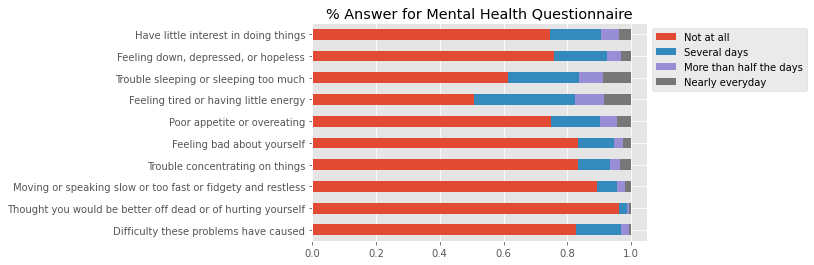

In [ ]:
plt.style.use('ggplot')

tmp.T.plot(kind = 'barh', stacked = True)
plt.legend(['Not at all', 'Several days', 'More than half the days', 'Nearly everyday'], 
          bbox_to_anchor=(1, 1))
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
           ['Have little interest in doing things', 
            'Feeling down, depressed, or hopeless', 
            'Trouble sleeping or sleeping too much' , 
            'Feeling tired or having little energy', 
            'Poor appetite or overeating', 
            'Feeling bad about yourself', 
            'Trouble concentrating on things', 
            'Moving or speaking slow or too fast or fidgety and restless',
            'Thought you would be better off dead or of hurting yourself', 
            'Difficulty these problems have caused'])
plt.title('% Answer for Mental Health Questionnaire')

plt.gca().invert_yaxis()
plt.show()

In [ ]:
# sum of each row as MH_Index
DPQ['MH_Index'] = DPQ.sum(axis = 1)

In [ ]:
DPQ = DPQ[DPQ.DPQ020 > 0] #removing people who donot feel depressed as they are not of interest in this study & may skew the data

No handles with labels found to put in legend.


Text(0, 0.5, '%')

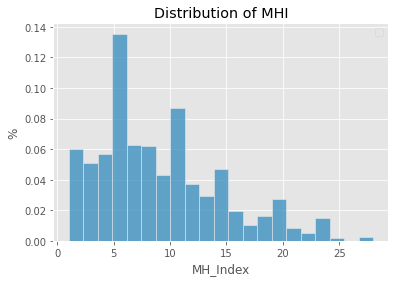

In [ ]:
sns.histplot(DPQ['MH_Index'], stat='density')
plt.legend()
plt.title("Distribution of MHI")
plt.ylabel('%')

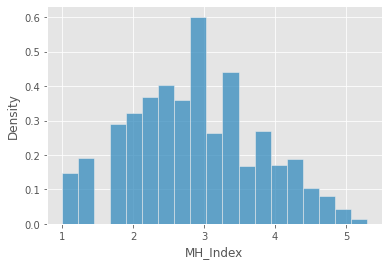

In [ ]:
sns.histplot(np.sqrt(DPQ['MH_Index']), stat='density')
DPQ['MH_Index_sq'] = np.sqrt(DPQ['MH_Index'])

In [ ]:
df.SEQN = df.SEQN.astype('str')

In [ ]:
# merge DV to narrow down the subjects
MHI = DPQ[['SEQN', 'MH_Index', 'MH_Index_sq']]
select_df = MHI.merge(df, on ="SEQN")

In [ ]:
select_df

,SEQN,MH_Index,MH_Index_sq,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,...,RHQ070,RHQ074,RHQ076,RHQ078,RHQ131,RHD143,RHQ160,RHQ162,RHQ163,RHQ166,RHQ169,RHQ172,RHD173,RHQ171,RHD180,RHD190,RHQ197,RHQ200,RHD280,RHQ291,RHQ305,RHQ332,RHQ420,RHQ540,RHQ542A,RHQ542B,RHQ542C,RHQ542D,RHQ554,RHQ560Q,RHQ560U,RHQ570,RHQ576Q,RHQ576U,RHQ580,RHQ586Q,RHQ586U,RHQ596,RHQ602Q,RHQ602U
0,93713.0,9.0,3.000000,10.0,2.0,1.0,67.0,NaN,3.0,3.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,3.0,3.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,1.0,4.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93717.0,6.0,2.449490,10.0,2.0,1.0,22.0,NaN,3.0,3.0,2.0,NaN,1.0,2.0,1.0,1.0,NaN,NaN,3.0,5.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,5.397605e-79,5.397605e-79,5.397605e-79,1.0,2.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93740.0,4.0,2.000000,10.0,2.0,1.0,72.0,NaN,4.0,4.0,1.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,2.0,3.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,NaN,1.0,1.0,5.397605e-79,5.397605e-79,1.000000e+00,1.0,4.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,93757.0,6.0,2.449490,10.0,2.0,1.0,63.0,NaN,3.0,3.0,2.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,4.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,5.397605e-79,5.397605e-79,1.000000e+00,1.0,4.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,93758.0,12.0,3.464102,10.0,2.0,2.0,55.0,NaN,3.0,3.0,1.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,5.397605e-79,5.397605e-79,5.397605e-79,2.0,3.0,1.0,1.0,...,NaN,2.0,2.0,9.0,1.0,NaN,2.0,1.0,18.0,5.397605e-79,2.0,1.0,18.0,2.0,18.0,22.0,NaN,NaN,1.0,34.0,9.0,NaN,1.0,1.0,10.0,NaN,NaN,NaN,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217,102916.0,1.0,1.000000,10.0,2.0,1.0,66.0,NaN,2.0,2.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,4.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,5.397605e-79,5.397605e-79,2.000000e+00,1.0,4.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1218,102922.0,3.0,1.732051,10.0,2.0,1.0,31.0,NaN,4.0,4.0,1.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,3.0,5.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,6.0,6.0,5.397605e-79,3.000000e+00,5.397605e-79,2.0,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1219,102935.0,15.0,3.872983,10.0,2.0,2.0,27.0,NaN,3.0,3.0,1.0,NaN,2.0,NaN,1.0,1.0,NaN,NaN,5.0,6.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,5.397605e-79,5.397605e-79,5.397605e-79,1.0,2.0,3.0,1.0,...,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1220,102953.0,4.0,2.000000,10.0,2.0,1.0,42.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,2.

**Now we perform EDA on several factors/features which we believe would contribute to the Mental Health Index.**

**DEMOGRAPHICS**

**1. Age**

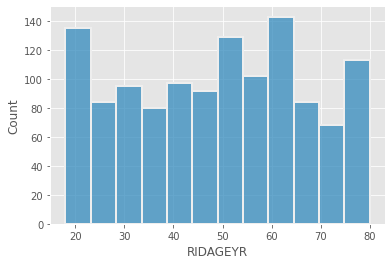

In [ ]:
sns.histplot(select_df['RIDAGEYR'], kde=False, lw=2, stat='count')

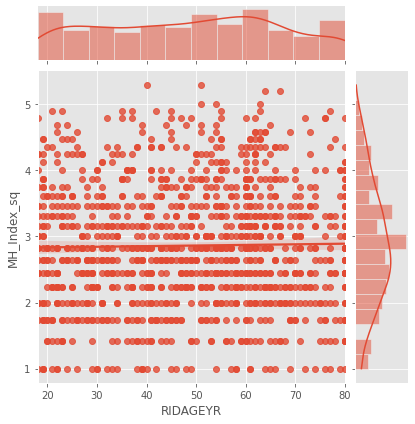

In [ ]:
sns.jointplot(x="RIDAGEYR", y="MH_Index_sq", data=select_df, kind="reg")

In [ ]:
select_df['RIDAGEYR'].corr(select_df['MH_Index'])

0.015706862955665785

It is interesting to see that there is no correlation between age and mental health index.

In [ ]:
# Survey age was capped at 80, meaning age of anyone older was inputted as 80. To adapt to this, I'll add some noise to this data by dispersing
# the data with age 80 to be random integer between 80 to 90.
select_df['age'] = select_df.RIDAGEYR.apply(lambda x: np.random.randint(80, 90, 1)[0] if x == 80 else x)  # new column 'age' .

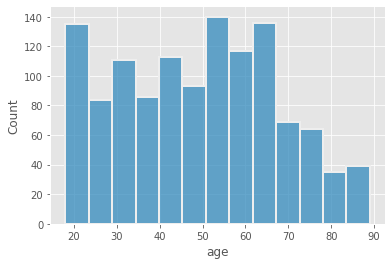

In [ ]:
sns.histplot(select_df['age'], kde=False, lw=2, stat='count')

**2. Gender**

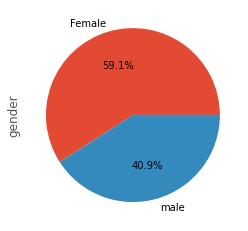

In [ ]:
select_df['gender'] = select_df['RIAGENDR']
labels=['Female', 'male']
select_df["gender"].value_counts(normalize=True).plot(kind='pie', labels=labels, autopct='%1.1f%%')  # 1 = MALE, 2 = FEMALE

59% Female and 41% male

In [ ]:
select_df['gender'] = select_df['gender'].replace(1.0, 'M')
select_df['gender'] = select_df['gender'].replace(2.0, 'F')

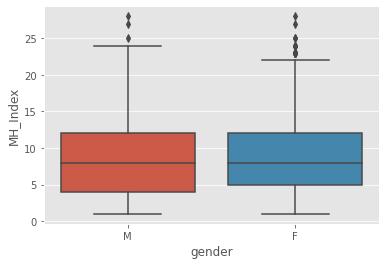

In [ ]:
sns.boxplot(x="gender", y="MH_Index", data=select_df)

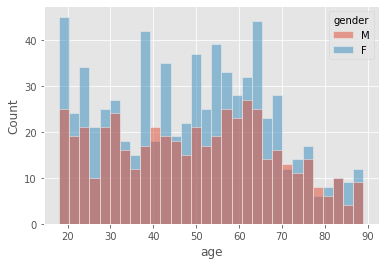

In [ ]:
sns.histplot(x='age', hue='gender', bins=30, data=select_df)

Now we want to answer if there is any effect on the mental_health index variable because of gender, i.e. if males and females have a significantly different distribution of mh_index

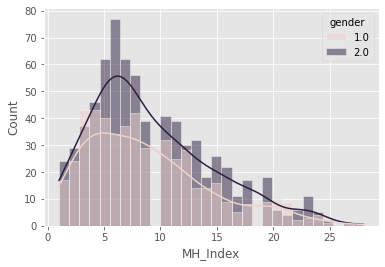

In [ ]:
sns.histplot(x='MH_Index', hue='gender', bins=30, data=select_df, kde=True)

In [ ]:
select_df[select_df['gender']=='M']['MH_Index'].describe()

count    500.000000
mean       8.794000
std        5.504194
min        1.000000
25%        4.000000
50%        8.000000
75%       12.000000
max       28.000000
Name: MH_Index, dtype: float64

In [ ]:
select_df[select_df['gender']=='F']['MH_Index'].describe()

count    722.000000
mean       9.196676
std        5.463036
min        1.000000
25%        5.000000
50%        8.000000
75%       12.000000
max       28.000000
Name: MH_Index, dtype: float64

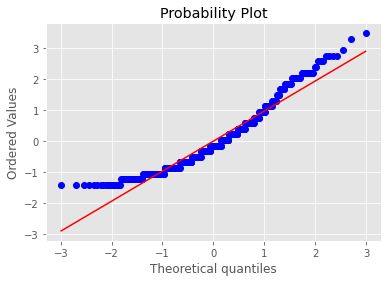

In [ ]:
male_mhi = select_df[select_df['gender']=='M']['MH_Index']
var = (male_mhi - male_mhi.mean())/(male_mhi.std())
st.probplot(x=var,dist='norm', plot=plt)
plt.show()

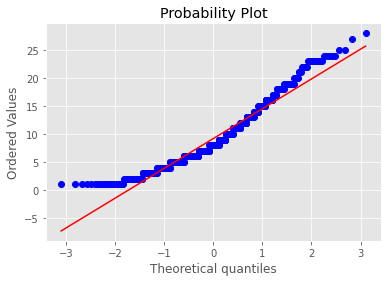

In [ ]:
st.probplot(x=select_df[select_df['gender']=='F']['MH_Index'], dist='norm', plot=plt)
plt.show()

From the qq-plots it looks like the distribution of male and female are not normal and the data is skewed to the right. Anyways the sample is large enough that the distribution of the mean will be normal. So t-test will also be fine.

To check if the cdf of mh_index for male and female are same or not, we can do a KS-test which assumes no prior distribution of the data.

Null hypothesis: Two sample datasets come from the same distribution

In [ ]:
st.ks_2samp(select_df[select_df['gender']=='M']['MH_Index'], select_df[select_df['gender']=='F']['MH_Index'])

Ks_2sampResult(statistic=0.06563434903047091, pvalue=0.1482701661772603)

The p-value obtained is high, that is at significance level of 0.05, MH index scores of male and female are not significantly different. Therefore, while making the model, we will not have the 'gender' factor. (We cannot reject the null hypothesis)

**3. Total number of people in household**

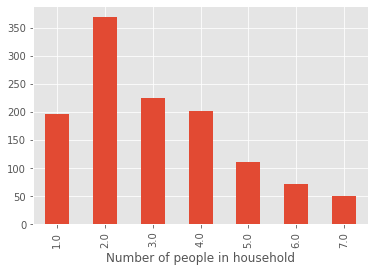

In [ ]:
ax = select_df['DMDHHSIZ'].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Number of people in household')
plt.show()

Most households have 2 people, followed by 3, 1, 4

Let's see if number of people in a household have any effect on MH_Index.

In [ ]:
select_df['total_household'] = select_df['DMDHHSIZ']

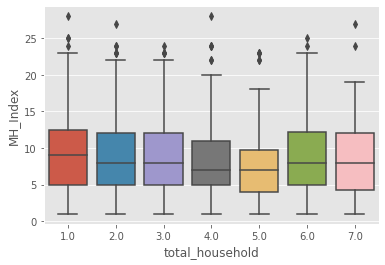

In [ ]:
sns.boxplot(x="total_household", y="MH_Index", data=select_df)

It seems that number of people in a household doesn't have any influence on our target variable.

But we know that there are different types of household like, Single mom and a couple are both two people households but their living situation can be very different. We will have a deeper look into this and see if there is any relationship or not with our target variable.

In [ ]:
# DMDHHSZA : Number of children 5 years or younger in the HH
# DMDHHSZB : Number of children aged 6-17 years old in the HH
select_df['n_dependents'] = select_df['DMDHHSZA'] + select_df['DMDHHSZB'] # This column represents number of children in a HH
select_df['n_dependents'] = select_df['n_dependents'].apply(lambda x: int(x))
select_df['n_adults'] = select_df['total_household'] - select_df['n_dependents'] # This column represents number of adults in a HH

In [ ]:
select_df['n_dependents'].value_counts()

0    762
1    227
2    121
3     78
4     25
5      8
6      1
Name: n_dependents, dtype: int64

In [ ]:
select_df['n_adults'].value_counts()

2.0    544
3.0    245
1.0    237
4.0    151
5.0     40
6.0      4
7.0      1
Name: n_adults, dtype: int64

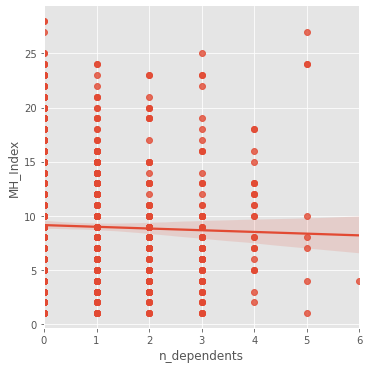

In [ ]:
sns.lmplot(x="n_dependents", y="MH_Index", data=select_df)


It seems like there could be (weak) relationship, but that's a maybe. Let's check.

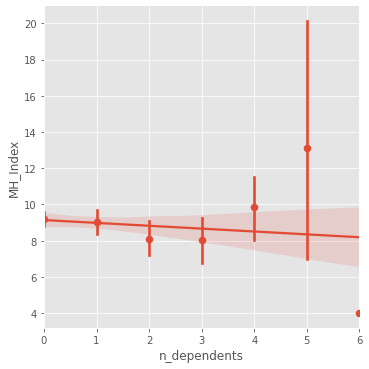

In [ ]:
sns.lmplot(x="n_dependents", y="MH_Index", data=select_df, x_estimator=np.mean)

In [ ]:
# To see if there is any statistically significance difference between these groups, we will run a kruskal wallis test.
x1 = select_df[select_df.n_dependents == 0].MH_Index
x2 = select_df[select_df.n_dependents == 1].MH_Index
x3 = select_df[select_df.n_dependents == 2].MH_Index
x4 = select_df[select_df.n_dependents == 3].MH_Index
x5 = select_df[select_df.n_dependents == 4].MH_Index
x6 = select_df[select_df.n_dependents == 5].MH_Index

st.kruskal(x1, x2, x3, x4, x5, x6)

KruskalResult(statistic=10.69718472058165, pvalue=0.05772570077695955)

We failed to reject the null at significance level of 0.05, because p-value is greater than 0.05.

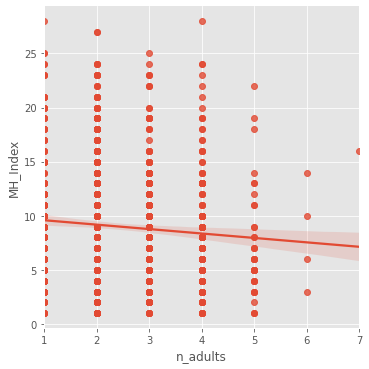

In [ ]:
# Lets look at number of adults.
sns.lmplot(x="n_adults", y="MH_Index", data=select_df)

In [ ]:
x1 = select_df[select_df.n_adults == 1].MH_Index
x2 = select_df[select_df.n_adults == 2].MH_Index
x3 = select_df[select_df.n_adults == 3].MH_Index
x4 = select_df[select_df.n_adults == 4].MH_Index
x5 = select_df[select_df.n_adults == 5].MH_Index
x6 = select_df[select_df.n_adults == 6].MH_Index
x7 = select_df[select_df.n_adults == 7].MH_Index

st.kruskal(x1, x2, x3, x4, x5)

KruskalResult(statistic=10.939132745409085, pvalue=0.027256662627727416)


At the significance level of 0.05, we reject the null. There are significant difference in MH Index between number of adults (one or more of the pairs at least). I will dive deeper into the relationship between number of adult and other variable.)

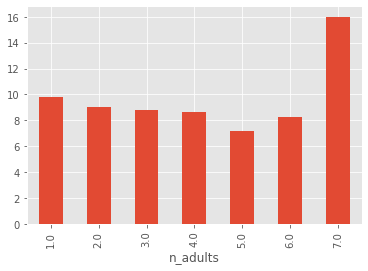

In [ ]:
select_df.groupby('n_adults').mean()['MH_Index'].plot(kind='bar')

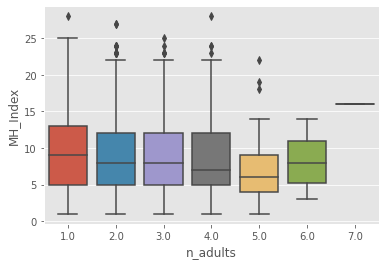

In [ ]:
sns.boxplot(x='n_adults',y='MH_Index', data=select_df)

In [ ]:
select_df['n_adults'].corr(select_df['MH_Index'])

-0.07909077562342119

Low correlation.

In [ ]:
select_df['n_adults'].value_counts()

2.0    544
3.0    245
1.0    237
4.0    151
5.0     40
6.0      4
7.0      1
Name: n_adults, dtype: int64

n_adults = 1,2,3,4 have similar distribution (p-value>0.05, cannot reject null hypothesis).
5 kaand kar rha h...waise bhi kam number mai hai.

**4.Veterans**

In [ ]:
# If they have served in US Army or in foreign country, 1, otherwise 0.
select_df['veteran'] = np.where((select_df.DMQMILIZ == 1) | (select_df.DMQADFC == 1), 1, 0)

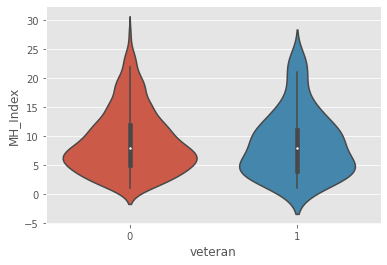

In [ ]:
sns.violinplot(x="veteran", y="MH_Index", data=select_df)

The distributions look similar.

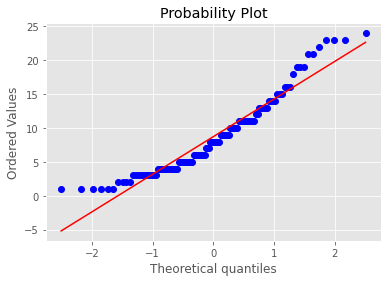

In [ ]:
st.probplot(x=select_df[select_df['veteran']==1]['MH_Index'], dist='norm', plot=plt)
plt.show()

Skewed right, not normal.

In [ ]:
# 2-sample KS test
st.ks_2samp(select_df[select_df['veteran']==1]['MH_Index'], select_df[select_df['veteran']==0]['MH_Index'])

Ks_2sampResult(statistic=0.07690480714421433, pvalue=0.5458021127444125)

Since p-value is greater than 0.05 we cannot reject the null hypotheses. Therefore we will not factor in this variable while making the model.

In [ ]:
st.ttest_ind(select_df[select_df['veteran']==1]['MH_Index'], select_df[select_df['veteran']==0]['MH_Index'])

Ttest_indResult(statistic=-0.6214147849337005, pvalue=0.5344428377863468)

**5.Education**

In [ ]:
select_df['DMDEDUC3'].value_counts() # 13: high school graduate (3)

13.0    26
15.0    14
11.0     5
10.0     2
14.0     2
12.0     2
66.0     1
Name: DMDEDUC3, dtype: int64

In [ ]:
select_df['DMDEDUC2'].value_counts()

4.0    411
3.0    307
5.0    189
2.0    147
1.0    113
9.0      3
Name: DMDEDUC2, dtype: int64

In [ ]:
select_df.loc[select_df[(select_df['DMDEDUC3']==13.0) | (select_df['DMDEDUC3']==14.0)].index ,'DMDEDUC2'] = 3.0 # Because 13 and 3 are similar, both are high school graduate
select_df.loc[select_df[(select_df['DMDEDUC3']==10.0) | (select_df['DMDEDUC3']==11.0) | (select_df['DMDEDUC3']==12.0)].index ,'DMDEDUC2'] = 2.0
select_df.loc[select_df[(select_df['DMDEDUC3']==66.0)].index, 'DMDEDUC2'] = 1.0
select_df.loc[select_df[(select_df['DMDEDUC3']==15.0)].index, 'DMDEDUC2'] = 4.0
select_df['DMDEDUC2'] = select_df['DMDEDUC2'].replace(9.0, 3.0) # 9 is don't knows which we replace by average education

In [ ]:
select_df['DMDEDUC2'].value_counts()

4.0    425
3.0    338
5.0    189
2.0    156
1.0    114
Name: DMDEDUC2, dtype: int64

In [ ]:
# 1.0 = less than 9th grade
# 2.0 = 9-11th grade (Includes 12th grade with no diploma)
# 3.0 = High school graduate/GED or equivalent
# 4.0 = Some college or AA degree
# 5.0 = College graduate or above

In [ ]:
select_df['education'] = select_df['DMDEDUC2']

In [ ]:
select_df.groupby('education').mean()['MH_Index']

education
1.0    10.482456
2.0     9.397436
3.0     9.405325
4.0     8.851765
5.0     7.592593
Name: MH_Index, dtype: float64

As the highest education level received/completed is increasing the mh_index mean is also dropping. Students whose highest degree is less than 9th grade are scoring more on the mh_index, while those who have graduated colleges are doing good relatively. This makes sense because having a good education is essential in many aspects of well being!

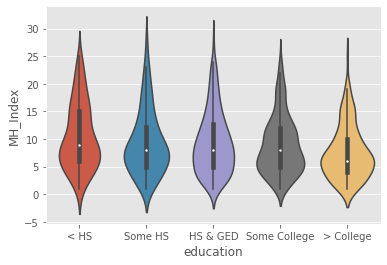

In [ ]:
sns.violinplot(x="education", y="MH_Index", data=select_df)
plt.xticks([0, 1, 2, 3, 4], 
           labels = ['< HS', 'Some HS', 'HS & GED', 
                    'Some College', '> College'])
plt.show()

In [ ]:
# Is there any significance difference between the groups? To answer this we will do a kruskal wallis test!
x1 = select_df[select_df.education == 1].MH_Index
x2 = select_df[select_df.education == 2].MH_Index
x3 = select_df[select_df.education == 3].MH_Index
x4 = select_df[select_df.education == 4].MH_Index
x5 = select_df[select_df.education == 5].MH_Index

st.kruskal(x1, x2, x3, x4, x5)

KruskalResult(statistic=21.72073205798893, pvalue=0.00022777237717269314)

The p-value obtained is less than 0.05 and hence we reject the null hypothesis. Therefore there is significant difference between different education level.

In [ ]:
select_df['education'].corr(select_df['MH_Index'])

-0.12963726150061228

**6)Income**

In [ ]:
# INDHHIN2 - Annual household income
select_df['income'] = select_df['INDHHIN2']
cond = [
    select_df.income == 1, 
    select_df.income == 2, 
    select_df.income == 3, 
    select_df.income == 4, 
    select_df.income == 5, 
    select_df.income == 6, 
    select_df.income == 7, 
    select_df.income == 8, 
    select_df.income == 9, 
    select_df.income == 10, 
    select_df.income == 12, 
    select_df.income == 13, 
    select_df.income == 14, 
    select_df.income == 15 
]
vals = [np.mean([0, 4999]), np.mean([5000, 9999]), np.mean([10000, 14999]), 
       np.mean([15000, 19999]), np.mean([20000, 24999]), np.mean([25000, 34999]), 
       np.mean([35000, 44999]), np.mean([45000, 54999]), np.mean([55000, 64999]), 
       np.mean([65000, 74999]), np.mean([20000, 40000]), np.mean([0, 20000]), 
       np.mean([75000, 99999]), np.mean([100000, 200000])]

select_df['income_avg'] = np.select(cond, vals, np.nan) # Income were given in ranges, so we took the mean of each range and now this column represents the average income.

In [ ]:
select_df['income_avg'].isnull().sum()

125

In [ ]:
select_df['income_avg'].corr(select_df['MH_Index'])

-0.15850733182527532

In [ ]:
select_df.groupby('income_avg').mean()['MH_Index']

income_avg
2499.5       8.745455
7499.5      10.690476
10000.0      9.000000
12499.5     10.445783
17499.5      9.622222
22499.5     10.179775
29999.5      9.725191
30000.0      8.484848
39999.5      8.793893
49999.5      9.585366
59999.5      7.046875
69999.5      7.125000
87499.5      7.344444
150000.0     7.556391
Name: MH_Index, dtype: float64

As average income increases the mean MH_index decreases. Although not a strong relation, but we see a drop. Many other factors interact with income!

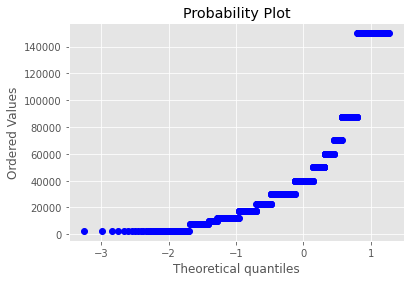

In [ ]:
st.probplot(x=select_df['income_avg'], dist='norm', plot=plt)
plt.show()

As expected, this column is skewed to right.

In [ ]:
select_df['income_avg'].skew()

1.3032938133260157

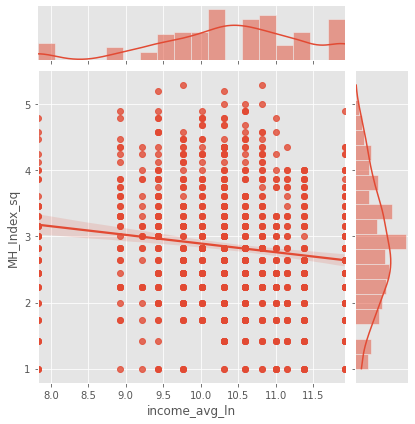

In [ ]:
tmp = select_df.copy()
tmp['income_avg_ln'] = np.log(tmp.income_avg)
sns.jointplot(x="income_avg_ln", y="MH_Index_sq", data=tmp, kind="reg")

There seems to be some correlation here.

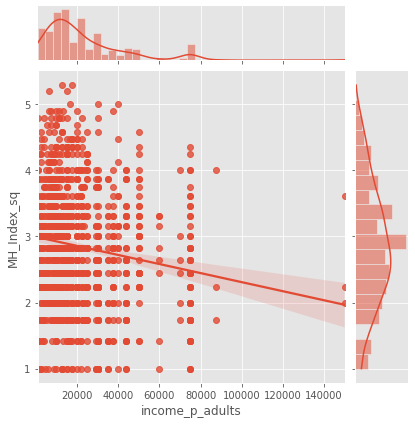

In [ ]:
# Lets look at average income per adult
tmp = tmp[tmp.n_adults != 0]
tmp['income_p_adults'] = tmp.income_avg/tmp.n_adults

sns.jointplot(x="income_p_adults", y="MH_Index_sq", data=tmp, kind="reg")

In [ ]:
tmp['income_p_adults'].corr(tmp['MH_Index'])

-0.1430072558655413

Filling the missing values.

Since distribution is skewed, I'll use the median ratio of income to number of adults for misisng incomes.
I will calculate the income by multiplying median ratio to the number of adults

In [ ]:
med_ratio = tmp['income_p_adults'].median()
select_df.income_avg = select_df.income_avg.fillna(select_df.n_adults * med_ratio)

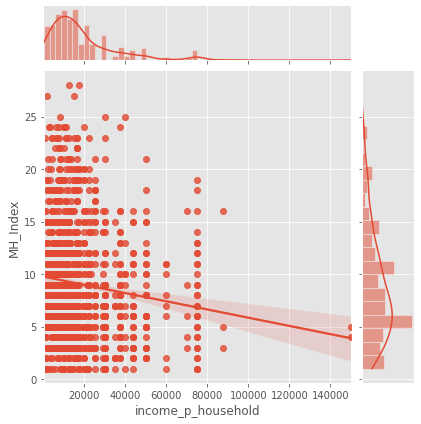

In [ ]:
# Lets look at avg_income per member of household.
select_df['income_p_household'] = select_df['income_avg'] / select_df['total_household']
sns.jointplot(x="income_p_household", y="MH_Index", data=select_df, kind="reg")

In [ ]:
select_df['income_p_household'].corr(select_df['MH_Index'])

-0.1201594551238261

In [ ]:
select_df['income_avg'].corr(select_df['MH_Index'])

-0.15938836076298837

Income related features :- average income, average income per adult in the household, average income per member of household.

All three show a negative correlation with mh_index. Average income shows the highest (most negative) correlation with the index.

**7) Race**

In [ ]:
# RIDRETH3 : Race/Hispanic origin w/ NH Asian
select_df['RIDRETH3'].value_counts()

3.0    476
4.0    255
1.0    164
2.0    141
6.0    102
7.0     84
Name: RIDRETH3, dtype: int64

In [ ]:
select_df['race'] = select_df['RIDRETH3'].replace({1.0:'Mexican American',
                                                   2.0:'Other hispanic',
                                                   3.0:'NH White',
                                                   4.0:'NH Black',
                                                   6.0:'NH Asian',
                                                   7.0:'Others'})

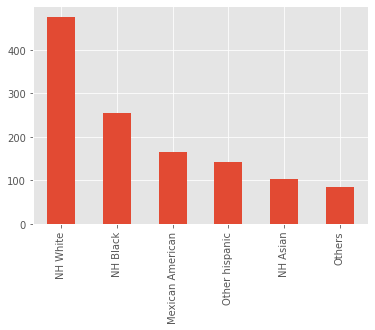

In [ ]:
select_df['race'].value_counts().plot(kind='bar')

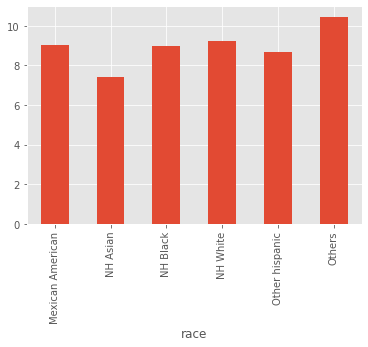

In [ ]:
select_df.groupby('race').mean()['MH_Index'].plot(kind='bar')

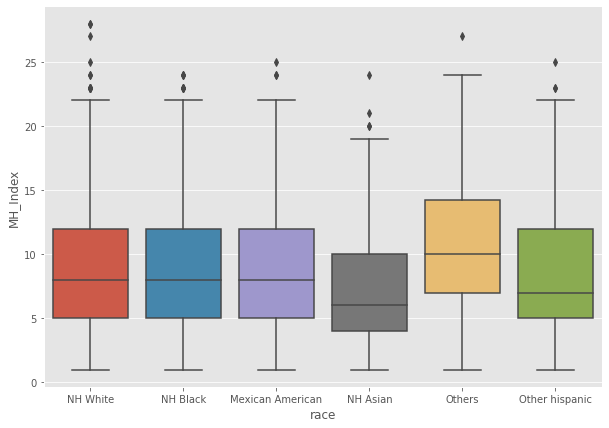

In [ ]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='race', y='MH_Index', data=select_df)

NH White, NH Black, Mexican american and other hispanic seem to have the same distribution and their mean index scores are also similar.

Others, which include the minority, multi-racial crowd have the highest mean MH_index score and NH Asian are doing better in terms of their index score i.e. they have the least mean score

The latter can be explained as follows, asians generally are good at academics/hard working which may be one of the reason for good index score, while the people from minority race may be facing less opportunities, have less resources and hence a high index score.

In [ ]:
# Lets look at income by race
select_df.groupby('race').mean()['income_avg']

race
Mexican American    47098.146341
NH Asian            76355.872549
NH Black            43169.507843
NH White            47923.250000
Other hispanic      48120.131206
Others              49940.065476
Name: income_avg, dtype: float64

Clearly, the average income of NH Asian is higher, which supports the reasons given earlier.

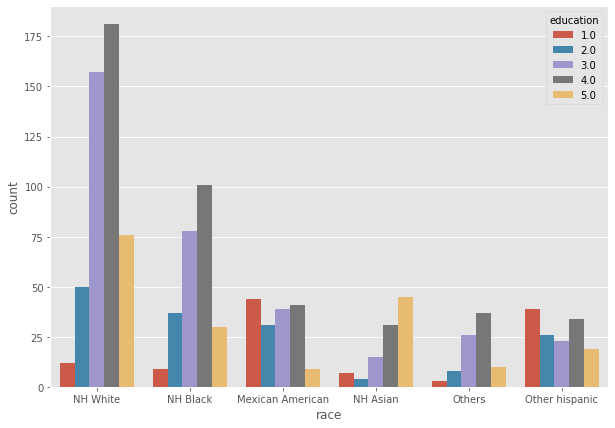

In [ ]:
# Lets look at the education level by race
plt.figure(figsize=(10, 7))
sns.countplot(x='race', hue='education', data=select_df)

Again, looking at higher education, NH Asians are doing good as compared to other races.

The others category has the least college graduates.

In [ ]:
# Is there any significance difference between the races? We will do a kruskal wallis test
x1 = select_df[select_df['race']=='Mexican American']['MH_Index'].values
x2 = select_df[select_df['race']=='NH Asian']['MH_Index'].values
x3 = select_df[select_df['race']=='NH Black']['MH_Index'].values
x4 = select_df[select_df['race']=='NH White']['MH_Index'].values
x5 = select_df[select_df['race']=='Others']['MH_Index'].values
x6 = select_df[select_df['race']=='Other hispanic']['MH_Index'].values

st.kruskal(x1, x2, x3, x4, x5, x6)

KruskalResult(statistic=18.96193411119055, pvalue=0.0019537699533948576)

The p-value obtained is less than 0.05 and hence we reject the null hypothesis. Therefore there is significant difference between different races.

In [ ]:
# x1, x3, x4, x6 seem to be similar. Lets find the p-value for this.
st.kruskal(x1, x3, x4, x6)

KruskalResult(statistic=1.0086539803705177, pvalue=0.7991579600132507)

Maybe we can group x1, x3, x4, x6 as one category. x2 as the other one. And x3 as the third category.

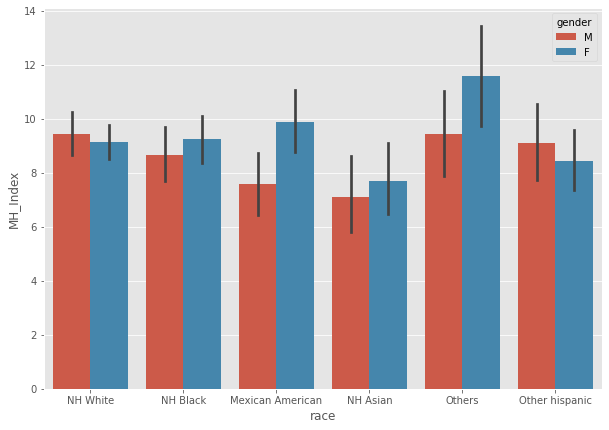

In [ ]:
plt.figure(figsize=(10, 7))
sns.barplot(x='race', y='MH_Index', hue='gender', data=select_df)

In [ ]:
select_df.groupby('gender').mean()['MH_Index']

gender
F    9.196676
M    8.794000
Name: MH_Index, dtype: float64

**8) Marital status**

In [ ]:
select_df['DMDMARTL'].value_counts()

1.0     441
5.0     251
3.0     180
2.0     121
6.0     108
4.0      68
77.0      1
Name: DMDMARTL, dtype: int64

In [ ]:
select_df['DMDMARTL'].isnull().sum()

52

In [ ]:
select_df['marital_st'] = np.where((select_df.DMDMARTL == 77) | (select_df.DMDMARTL.isnull()), 0, select_df.DMDMARTL)
select_df['marital_st_name'] = select_df['marital_st'].replace({0.0:'Others',
                                                                1.0:'Married',
                                                                2.0:'Widowed',
                                                                3.0:'Divorced',
                                                                4.0:'Seperated',
                                                                5.0:'Never Married',
                                                                6.0:'Living w_partner',})

In [ ]:
select_df['marital_st_name'].value_counts()

Married             441
Never Married       251
Divorced            180
Widowed             121
Living w_partner    108
Seperated            68
Others               53
Name: marital_st_name, dtype: int64

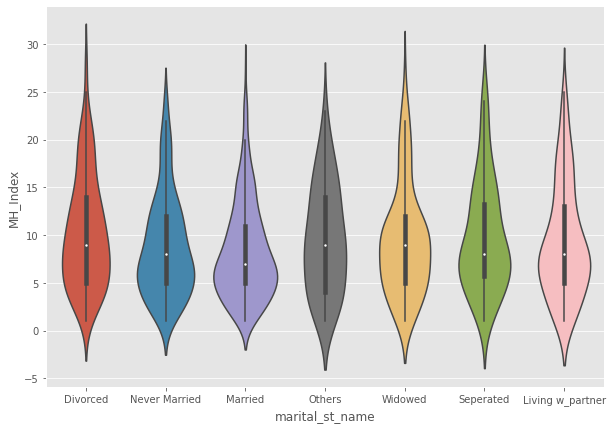

In [ ]:
plt.figure(figsize=(10, 7))
sns.violinplot(x="marital_st_name", y="MH_Index", data=select_df)
plt.show()

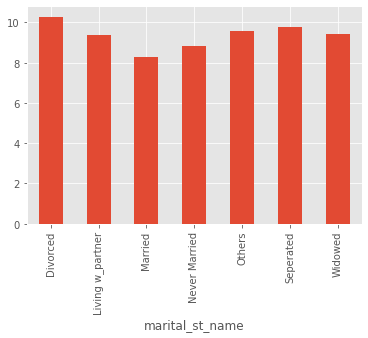

In [ ]:
select_df.groupby('marital_st_name').mean()['MH_Index'].plot(kind='bar')

Divorced category has the highest mean index score while the married category has the least mean index score. Makes sense.

In [ ]:
# Is there any significance difference between the marital status? We will do a kruskal wallis test
x1 = select_df[select_df['marital_st_name']=='Divorced']['MH_Index']
x2 = select_df[select_df['marital_st_name']=='Living w_partner']['MH_Index']
x3 = select_df[select_df['marital_st_name']=='Married']['MH_Index']
x4 = select_df[select_df['marital_st_name']=='Never Married']['MH_Index']
x5 = select_df[select_df['marital_st_name']=='Others']['MH_Index']
x6 = select_df[select_df['marital_st_name']=='Seperated']['MH_Index']
x7 = select_df[select_df['marital_st_name']=='Widowed']['MH_Index']

st.kruskal(x1, x2, x3, x4, x5, x6, x7)

KruskalResult(statistic=18.651887606570313, pvalue=0.004793775619106546)

Since p-value is less than 0.05 we can reject the null hypothesis and therefore there is a significant difference between the marital status.

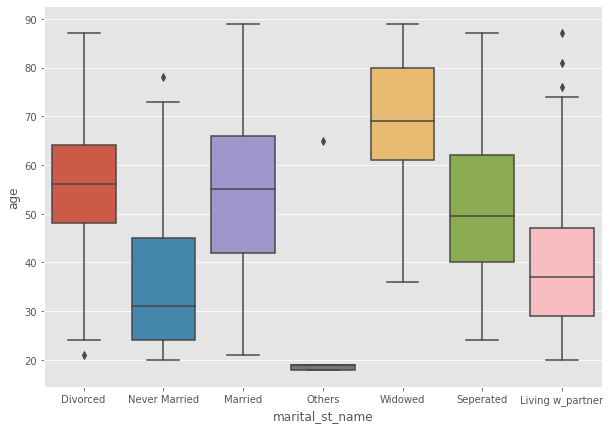

In [ ]:
# Interactions
# What about interaction between marital status and age?
plt.figure(figsize=(10, 7))
sns.boxplot(x = 'marital_st_name', y = 'age', data = select_df)

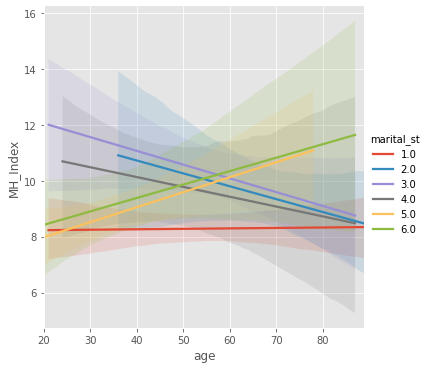

In [ ]:
sns.lmplot(x = 'age', y = 'MH_Index', hue = 'marital_st', data = select_df[select_df.marital_st != 0], scatter = False)

Being widowed, divorced and separated may have different relationship given age.
I'll group widowed, divorced, and separated (WDS) as one category. Then add an interaction between WDS and age and between WDS and gender.

In [ ]:
select_df['WDS_marital'] = np.where((select_df.marital_st == 2) | (select_df.marital_st == 3) | (select_df.marital_st == 4), 
                                   1, 0)

In [ ]:
# also never married
select_df['never_married'] = np.where((select_df.marital_st == 5) | (select_df.marital_st == 6), 1, 0)

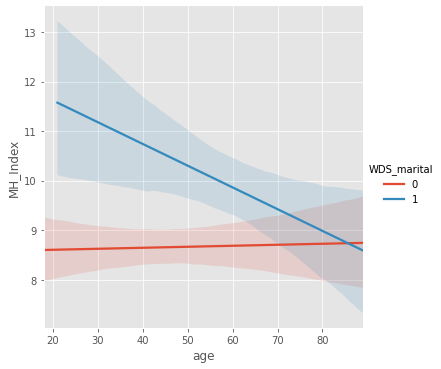

In [ ]:
sns.lmplot(x = 'age', y = 'MH_Index', hue = 'WDS_marital', data = select_df, scatter = False)
# not quite but will check in the model

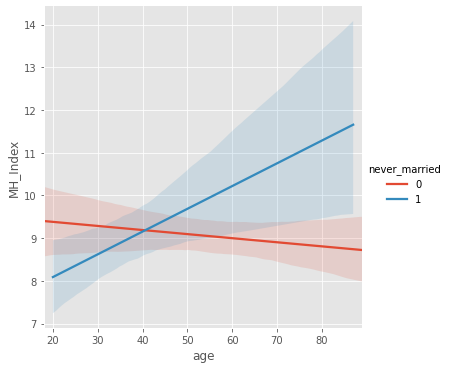

In [ ]:
sns.lmplot(x = 'age', y = 'MH_Index', hue = 'never_married', data = select_df, scatter = False)
# Huge error but seems like there's a relationship

In [ ]:
select_df['gender']

0       M
1       M
2       M
3       M
4       F
       ..
1217    M
1218    M
1219    F
1220    M
1221    M
Name: gender, Length: 1222, dtype: object

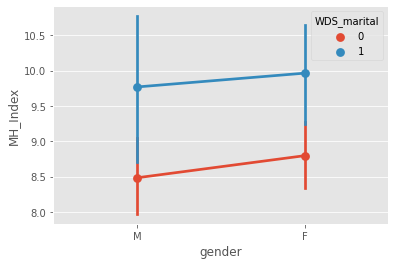

In [ ]:
sns.pointplot(x = 'gender', y = 'MH_Index', hue = 'WDS_marital', data = select_df, scatter = False)
# no interaction

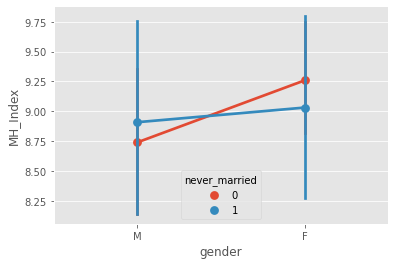

In [ ]:
sns.pointplot(x = 'gender', y = 'MH_Index', hue = 'never_married', data = select_df, scatter = False)
# maybe, a little, but huge error so not likely.

**Medical Condition**

**BMI**

In [ ]:
select_df['BMXBMI'].isnull().sum()

19

In [ ]:
female_mean = select_df[select_df.gender == 2].BMXBMI.mean()
male_mean = select_df[select_df.gender == 1].BMXBMI.mean()

In [ ]:
select_df['BMI'] = np.select([(select_df.BMXBMI.isnull()) & (select_df.gender == 2), 
                              (select_df.BMXBMI.isnull()) & (select_df.gender == 1)], 
                             [female_mean, male_mean], select_df.BMXBMI)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


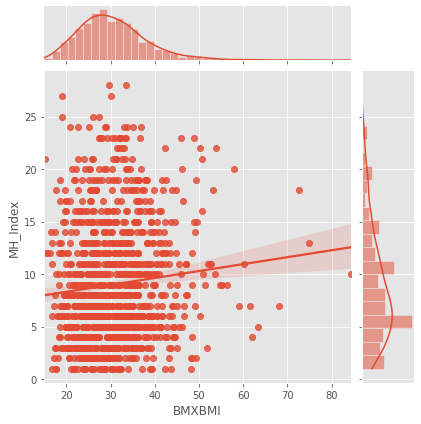

In [ ]:
sns.jointplot("BMXBMI", "MH_Index", data=select_df, kind="reg")

**Disability**

In [ ]:
select_df['disability'] = np.where((select_df.DLQ050 == 1) | (select_df.DLQ060 == 1) |
                                  (select_df.DLQ080 == 1) | (select_df.DLQ020 == 1) | 
                                  (select_df.DLQ010 == 1), 1, 0)

In [ ]:
select_df.disability.isnull().sum()

0

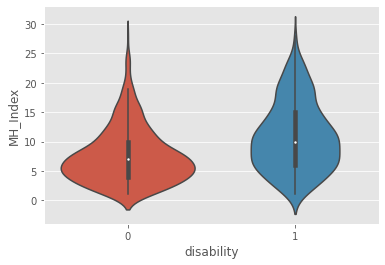

In [ ]:
sns.violinplot(x="disability", y="MH_Index", data=select_df)

In [ ]:
st.ttest_ind(select_df.MH_Index[select_df.disability == 0], 
             select_df.MH_Index[select_df.disability == 1])

# statistically significant difference between group

Ttest_indResult(statistic=-11.04738135505902, pvalue=4.1444162795852894e-27)

**Cancer**

In [ ]:
select_df['cancer'] = np.where((select_df.MCQ220 == 1) & (select_df.MCQ230A != 99), 1, 0)

In [ ]:
# find when it was diagnosed and how long it has been
select_df['cancer_d_yr'] = np.where((select_df['MCD240A'].isnull()) | (select_df['MCD240A'] == 99999), 0, 
                                     select_df['MCD240A'])

select_df['yr_since_cancer'] = np.where((select_df['cancer'] == 1), select_df['age'] - select_df['cancer_d_yr'], 0)

In [ ]:
# remove negative values (possibly due to some questions with cap on the age limit)
select_df['yr_since_cancer'] = np.where(select_df['yr_since_cancer'] < 0, 0, select_df['yr_since_cancer'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


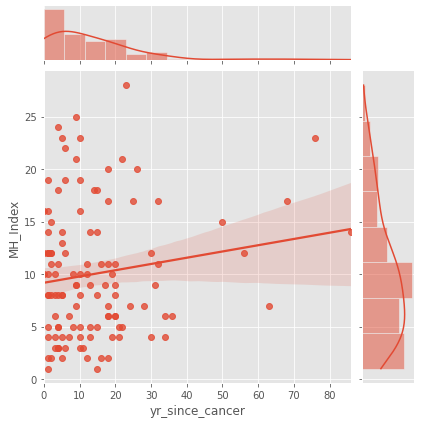

In [ ]:
sns.jointplot("yr_since_cancer", "MH_Index", data=select_df[select_df.cancer == 1], kind="reg")

**Physical Recreational Activity**

In [ ]:
select_df["PAQ665"].value_counts()

2.0    823
1.0    399
Name: PAQ665, dtype: int64

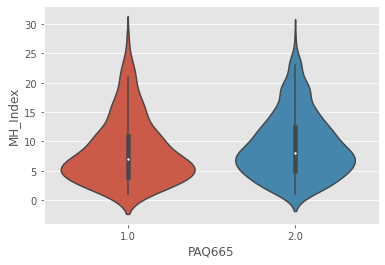

In [ ]:
sns.violinplot(x="PAQ665", y="MH_Index", data=select_df)

Physical Recreational Activity doesn't seem to have a direct impact on MHI as both distributions look pretty similar

**Number of work hours**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


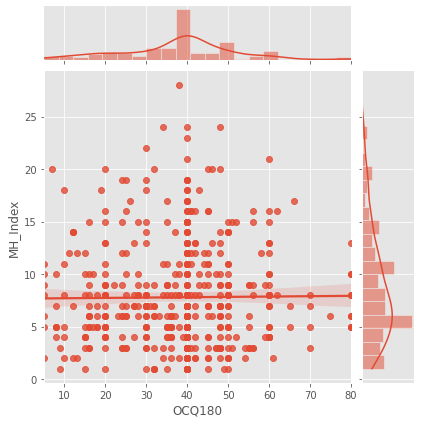

In [ ]:
sns.jointplot("OCQ180", "MH_Index", data=select_df, kind="reg")

There does not seem to be a correlation between MHI & number of work hours per week

**Substance Abuse**

**Smoking**

In [ ]:
# This is used to find if the person is still smoking or not which can act as a variable for the model 
cond = [(select_df.SMQ020 == 1) & (select_df.SMQ040 == 1), 
        (select_df.SMQ020 == 1) & (select_df.SMQ040 == 2), 
        (select_df.SMQ020 == 1) & (select_df.SMQ040 == 3)]
vals = [3, 2, 1] #[smoker, occasional smoker, quitter, non-smoker]
select_df['smoker'] = np.select(cond, vals, 0)

In [ ]:
# If don't know, add median number, if missing add 0
select_df['cig_init_yr'] = np.where(select_df['SMD030'] == 999, select_df['SMD030'].median(),
                                   select_df['SMD030'])
# years since quit smoking 
select_df['cig_quit_yr'] = np.where(select_df['SMQ050Q'] == 99999, select_df['SMQ050Q'].median(), 
                                    np.where(select_df['SMQ050Q'] == 66666, 50, 
                                             select_df['SMQ050Q']))
select_df['avg_n_cig'] = np.where(select_df['SMD650'] == 999, select_df['SMD650'].median(), 
                                    np.where(select_df['SMD650'] == 777, np.nan, 
                                             select_df['SMD650']))

In [ ]:
# fill NA with 0
select_df['cig_init_yr'] = select_df['cig_init_yr'].fillna(0)
select_df['cig_quit_yr'] = select_df['cig_quit_yr'].fillna(0)
select_df['avg_n_cig'] = select_df['avg_n_cig'].fillna(0)

**Marijuana**

In [ ]:
select_df['n_marijuana'] = np.where(select_df['DUQ219'] == 7, 0,
                                   select_df['DUQ219'])
select_df['n_marijuana'] = np.where(select_df['DUQ219'] == 9, select_df['DUQ219'].median(),
                                   select_df['DUQ219'])
select_df['n_marijuana'] = np.where(select_df['DUQ219'] == 3, 4,
                                   select_df['DUQ219'])
select_df['n_marijuana'] = np.where(select_df['DUQ219'] == 4, 6,
                                   select_df['DUQ219'])


**Cocaine**

In [ ]:
# For cocaine
select_df['n_cocaine'] = np.where((select_df['DUQ272'].isnull()) | 
                                  (select_df['DUQ272'] == 77), 0, 
                                 select_df['DUQ272'])

**Heroine & Meth**

In [ ]:
select_df['heroine'] = np.where((select_df['DUQ290'] == 1), 1, 0) # Ever used heroin 
select_df['meth'] = np.where((select_df['DUQ330'] == 1), 1, 0) # Ever used meth

select_df['heroine'].value_counts() 

0    1182
1      40
Name: heroine, dtype: int64

**Based on our above Exploratory Data Analysis we now try to create a regression model for MHI**

**The goal here is to not predict the MHI well but to finally figure out & summarise the important factors & also quantify their contribution (either positively or negatively) to Mental Health through the obtained coefficients.**

Initially we list all features which we have explored.

In [ ]:
cols = ['MH_Index', 'age', 'gender', 'total_household',
        'n_dependents', 'n_adults', 'veteran', 'education', 'income_avg', 'income_p_household',
        'race', 'marital_st_name', 'WDS_marital', 'never_married', 'BMI', 'disability', 
        'cancer', 'cancer_d_yr', 'yr_since_cancer', 'PAQ665', 'OCQ180', 'smoker',
        'cig_init_yr', 'cig_quit_yr', 'avg_n_cig', 'n_marijuana', 'n_cocaine',
        'heroine', 'meth']
current_df = select_df.copy()[cols]
print(current_df.shape)

(1222, 29)


Now we remove features which did not seem to contribute much to Mental Health through our EDA.

In [ ]:
current_df['WDSXAge'] = current_df['WDS_marital'] * current_df['age']
current_df['NeverMarriedXAge'] = current_df['never_married'] * current_df['age']
to_drop = ['age','gender','n_dependents','veteran','marital_st_name', 'WDS_marital', 'never_married','PAQ665', 'OCQ180','heroine', 'meth']
current_df.drop(to_drop,inplace=True,axis=1)
print(current_df.shape)

(1222, 20)


Handling Categorical Variables

In [ ]:
def dummies(x, prefix):
    """
    Helper function to make dummies
    Input: series or array, prefix string
    Output: dummy dataframe
    """
    x = x.dropna(axis = 0) # drop NA and make them integers (float throws an error)
    if x.dtype == 'float64':
      x = x.astype('int64')
    dummy = pd.get_dummies(x, prefix = prefix, drop_first = False)
    return dummy

def multi_dummy(df, cat_cols):
    df0 = df.copy()
    for c in cat_cols: 
        dummy = dummies(df0[c], c)
        df0 = pd.concat([df0, dummy], axis = 1)
        df0 = df0.drop(c, axis = 1)
    return df0

cat_cols = ['education','race']
current_df = multi_dummy(current_df, cat_cols)
print(current_df.shape)

(1222, 29)


Handling Multicolinearity: We remove features that are highly correlated with each other.

In [ ]:
def corr_high(df):
    """
    INPUT: Pandas Dataframe
    OUTPUT: return a dataframe with the pair correlation above 0.7
    """
    corr_df = abs(df.corr()).stack().reset_index()
    corr_df.columns = ['v1', 'v2', 'c']
    return corr_df, corr_df[(corr_df.c > 0.7) & (corr_df.c < 1)].sort_values(
        by = 'c', ascending = False)
    
corr_high(current_df)[1]

,v1,v2,c
211,cancer,cancer_d_yr,0.917536
239,cancer_d_yr,cancer,0.917536
303,smoker,avg_n_cig,0.757843
387,avg_n_cig,smoker,0.757843
31,total_household,n_adults,0.746965
59,n_adults,total_household,0.746965
91,income_avg,income_p_household,0.738393
119,income_p_household,income_avg,0.738393
301,smoker,cig_init_yr,0.728399
329,cig_init_yr,smoker,0.728399


In [ ]:
to_drop = ['cancer_d_yr','avg_n_cig','total_household','income_avg','cig_init_yr']
current_df.drop(to_drop,inplace=True,axis=1)
print(current_df.shape)

(1222, 24)


Now we remove features that have a low correlation with the dependent variable i.e. MHI

In [ ]:
print("Variables with low correlation with Dependent Variable")
for col in current_df.columns:
  corr = current_df['MH_Index'].corr(current_df[col])
  if abs(corr)<0.07:
    print(col,':',corr)

Variables with low correlation with Dependent Variable
cancer : 0.05877687757434241
cig_quit_yr : -0.016699903981666205
NeverMarriedXAge : 0.025182076189186133
education_2 : 0.025520826997439544
education_3 : 0.042142229775370244
education_4 : -0.024010363349619805
race_Mexican American : -0.0018551933100387833
race_NH Black : -0.0029912241826636457
race_NH White : 0.03179499631715214
race_Other hispanic : -0.022205978513484045


In [ ]:
to_drop = ['cancer','cig_quit_yr','NeverMarriedXAge','education_2','education_3','education_4','race_Mexican American',
           'race_NH Black','race_NH White','race_Other hispanic']
current_df.drop(to_drop,inplace=True,axis=1)
print(current_df.shape)

(1222, 14)


In [ ]:
for col in current_df.columns:
  print(col)

MH_Index
n_adults
income_p_household
BMI
disability
yr_since_cancer
smoker
n_marijuana
n_cocaine
WDSXAge
education_1
education_5
race_NH Asian
race_Others


We also drop marijuana & cocaine as the data is skewed & a large proportion of people for the given data had not consumed them.

In [ ]:
to_drop = ['n_marijuana','n_cocaine']
current_df.drop(to_drop,inplace=True,axis=1)
print(current_df.shape)

(1222, 12)


In order to interpret the coefficients better we bring all the independent variables to a similar range of values. 

In [ ]:
current_df["WDSXAge"] = current_df["WDSXAge"]/current_df["WDSXAge"].max()
current_df["yr_since_cancer"] = current_df["yr_since_cancer"]/current_df["yr_since_cancer"].max()

def multi_log_transform(df, cols):
    """
    INPUT: PD Dataframe and a list of column names to be log_transformed
    OUTPUS: log_transformed df (removes existing columns)
    """
    df0 = df.copy()
    for c in cols:
        df0[f"{c}_ln"] = np.log(df0[c])
        df0 = df0.drop(c, axis = 1)
    return df0

log_cols = ['income_p_household', 'BMI']
current_df = multi_log_transform(current_df, log_cols)

current_df["income_p_household_ln"] = current_df["income_p_household_ln"]/current_df["income_p_household_ln"].max()
current_df["BMI_ln"] = current_df["BMI_ln"]/current_df["BMI_ln"].max()

In [ ]:
print(current_df.shape)
current_df.dropna(axis=0,inplace=True)
print(current_df.shape)

(1222, 12)
(1203, 12)


In [ ]:
data = current_df.to_numpy(dtype='float')
print(data.shape)
X = data[:,1:12]
Y = data[:,0]
print(X.shape)
print(Y.shape)

(1203, 12)
(1203, 11)
(1203,)


In [ ]:
# splitting data into train & test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=10) 
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1022, 11)
(181, 11)
(1022,)
(181,)


In [ ]:
#linear regression
linear_model = LinearRegression()
linear_model.fit(X_train,Y_train)
print("MHI Model:-")
print("Intercept:",linear_model.intercept_)
print("Coefficients-")
for i,col in enumerate(current_df.columns):
  if i!=0:
    print(col,':',linear_model.coef_[i-1])

MHI Model:-
Intercept: 8.242199061391542
Coefficients-
n_adults : -0.38342088042203354
disability : 2.538397975398956
yr_since_cancer : 4.116672152279168
smoker : 0.5091629789559708
WDSXAge : -0.04248542344980755
education_1 : 1.1153345544510165
education_5 : -0.5332325046651165
race_NH Asian : -0.18848870638818738
race_Others : 1.0779631310963191
income_p_household_ln : -4.0915020882569815
BMI_ln : 4.240441224399593


In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
Y_pred = linear_model.predict(X_test)
print("Mean Squared Error",mean_squared_error(Y_test,Y_pred))
print("R2 value",r2_score(Y_test,Y_pred))

Mean Squared Error 22.642592038138297
R2 value 0.19319709104673277


**Some other Trends in Data**

Mental health status on a yearly basis

In [ ]:
df5 = pd.read_sas('/content/drive/MyDrive/Colab_Notebooks/DS203/Project/MyData/DPQ_5.XPT', format = 'xport')
df7 = pd.read_sas('/content/drive/MyDrive/Colab_Notebooks/DS203/Project/MyData/DPQ_7.XPT', format = 'xport')
df9 = pd.read_sas('/content/drive/MyDrive/Colab_Notebooks/DS203/Project/MyData/DPQ_9.XPT', format = 'xport')
df11 = pd.read_sas('/content/drive/MyDrive/Colab_Notebooks/DS203/Project/MyData/DPQ_11.XPT', format = 'xport')
df13 = pd.read_sas('/content/drive/MyDrive/Colab_Notebooks/DS203/Project/MyData/DPQ_13.XPT', format = 'xport')
df15 = pd.read_sas('/content/drive/MyDrive/Colab_Notebooks/DS203/Project/MyData/DPQ_15.XPT', format = 'xport')

In [ ]:
dead =[]
dep=[]

In [ ]:
year =[]
mh_avg =[]
df5.SEQN = df5.SEQN.apply(lambda x: str(x))
for c in df5.columns[1:]:
    df5[c] = df5[c].apply(lambda x: np.nan if math.isnan(x) else int(x))
df5 = df5.replace(7, np.nan)
df5 = df5.replace(9, np.nan)
df5.DPQ100 = df5.DPQ100.replace(np.nan, 0)
df5 = df5.drop(df5[df5.isnull().sum(axis = 1) > 4].index, axis = 0)
tmp = df5.dropna().iloc[:, 1:10]
cols = list(df5.columns)[1:10]
cor_dict = {}
for c in cols: 
    Y = tmp[c]
    X = tmp.drop(c, axis = 1)
    corr_ = X.corrwith(Y)
    max_ = corr_[corr_ == max(corr_)]
    cor_dict[c] = (list(max_.index)[0], max_[0])
for k, v in cor_dict.items():
    df5[k] = df5[k].fillna(df5[v[0]])
df5 = df5.dropna(axis = 0)
df5['MH_Index'] = df5.sum(axis = 1)
df5 = df5[df5.DPQ020 > 0]
df5['MH_Index_sq'] = np.sqrt(df5['MH_Index'])
df5.SEQN = df5.SEQN.astype('str')
year.append("2005-06")
mh_avg.append(df5["MH_Index"].mean())
dead.append(len(df5[(df5['DPQ090']==1) | (df5['DPQ090']==2)| (df5['DPQ090']==3)]))
dep.append(len(df5[(df5['DPQ020']==1) | (df5['DPQ020']==2)| (df5['DPQ020']==3)]))

In [ ]:
dead

[151]

In [ ]:
df7.SEQN = df7.SEQN.apply(lambda x: str(x))
for c in df7.columns[1:]:
   df7[c] = df7[c].apply(lambda x: np.nan if math.isnan(x) else int(x))
df7 = df7.replace(7, np.nan)
df7 = df7.replace(9, np.nan)
df7.DPQ100 = df7.DPQ100.replace(np.nan, 0)
df7 = df7.drop(df7[df7.isnull().sum(axis = 1) > 4].index, axis = 0)
tmp = df7.dropna().iloc[:, 1:10]
cols = list(df7.columns)[1:10]
cor_dict = {}
for c in cols:
   Y = tmp[c]
   X = tmp.drop(c, axis = 1)
   corr_ = X.corrwith(Y)
   max_ = corr_[corr_ == max(corr_)]
   cor_dict[c] = (list(max_.index)[0], max_[0])
for k, v in cor_dict.items():
   df7[k] = df7[k].fillna(df7[v[0]])
df7 = df7.dropna(axis = 0)
df7['MH_Index'] = df7.sum(axis = 1)
df7 = df7[df7.DPQ020 > 0]
df7['MH_Index_sq'] = np.sqrt(df7['MH_Index'])
df7.SEQN = df7.SEQN.astype('str')
year.append("2007-08")
mh_avg.append(df7["MH_Index"].mean())
dead.append(len(df7[(df5['DPQ090']==1) | (df7['DPQ090']==2)| (df7['DPQ090']==3)]))
dep.append(len(df7[(df5['DPQ020']==1) | (df7['DPQ020']==2)| (df7['DPQ020']==3)]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
df9.SEQN = df9.SEQN.apply(lambda x: str(x))
for c in df9.columns[1:]:
   df9[c] = df9[c].apply(lambda x: np.nan if math.isnan(x) else int(x))
df9 = df9.replace(7, np.nan)
df9 = df9.replace(9, np.nan)
df9.DPQ100 = df9.DPQ100.replace(np.nan, 0)
df9 = df9.drop(df9[df9.isnull().sum(axis = 1) > 4].index, axis = 0)
tmp = df9.dropna().iloc[:, 1:10]
cols = list(df9.columns)[1:10]
cor_dict = {}
for c in cols:
   Y = tmp[c]
   X = tmp.drop(c, axis = 1)
   corr_ = X.corrwith(Y)
   max_ = corr_[corr_ == max(corr_)]
   cor_dict[c] = (list(max_.index)[0], max_[0])
for k, v in cor_dict.items():
   df9[k] = df9[k].fillna(df9[v[0]])
df9 = df9.dropna(axis = 0)
df9['MH_Index'] = df9.sum(axis = 1)
df9 = df9[df9.DPQ020 > 0]
df9['MH_Index_sq'] = np.sqrt(df9['MH_Index'])
df9.SEQN = df9.SEQN.astype('str')
year.append("2009-10")
mh_avg.append(df9["MH_Index"].mean())

dead.append(len(df9[(df9['DPQ090']==1) | (df9['DPQ090']==2)| (df9['DPQ090']==3)]))
dep.append(len(df9[(df9['DPQ020']==1) | (df9['DPQ020']==2)| (df9['DPQ020']==3)]))

In [ ]:
mh_avg

[8.001883239171375, 8.923131672597865, 9.028449502133713]

In [ ]:
df11.SEQN = df11.SEQN.apply(lambda x: str(x))
for c in df11.columns[1:]:
   df11[c] = df11[c].apply(lambda x: np.nan if math.isnan(x) else int(x))
df11 = df11.replace(7, np.nan)
df11 = df11.replace(9, np.nan)
df11.DPQ100 = df11.DPQ100.replace(np.nan, 0)
df11 = df11.drop(df11[df11.isnull().sum(axis = 1) > 4].index, axis = 0)
tmp = df11.dropna().iloc[:, 1:10]
cols = list(df11.columns)[1:10]
cor_dict = {}
for c in cols:
   Y = tmp[c]
   X = tmp.drop(c, axis = 1)
   corr_ = X.corrwith(Y)
   max_ = corr_[corr_ == max(corr_)]
   cor_dict[c] = (list(max_.index)[0], max_[0])
for k, v in cor_dict.items():
   df11[k] = df11[k].fillna(df11[v[0]])
df11 = df11.dropna(axis = 0)
df11['MH_Index'] = df11.sum(axis = 1)
df11 = df11[df11.DPQ020 > 0]
df11['MH_Index_sq'] = np.sqrt(df11['MH_Index'])
df11.SEQN = df11.SEQN.astype('str')
year.append("2011-12")
mh_avg.append(df11["MH_Index"].mean())

dead.append(len(df11[(df11['DPQ090']==1) | (df11['DPQ090']==2)| (df11['DPQ090']==3)]))
dep.append(len(df11[(df11['DPQ020']==1) | (df11['DPQ020']==2)| (df11['DPQ020']==3)]))

In [ ]:
df13.SEQN = df13.SEQN.apply(lambda x: str(x))
for c in df13.columns[1:]:
   df13[c] = df13[c].apply(lambda x: np.nan if math.isnan(x) else int(x))
df13 = df13.replace(7, np.nan)
df13 = df13.replace(9, np.nan)
df13.DPQ100 = df13.DPQ100.replace(np.nan, 0)
df13 = df13.drop(df13[df13.isnull().sum(axis = 1) > 4].index, axis = 0)
tmp = df13.dropna().iloc[:, 1:10]
cols = list(df13.columns)[1:10]
cor_dict = {}
for c in cols:
   Y = tmp[c]
   X = tmp.drop(c, axis = 1)
   corr_ = X.corrwith(Y)
   max_ = corr_[corr_ == max(corr_)]
   cor_dict[c] = (list(max_.index)[0], max_[0])
for k, v in cor_dict.items():
   df13[k] = df13[k].fillna(df13[v[0]])
df13 = df13.dropna(axis = 0)
df13['MH_Index'] = df13.sum(axis = 1)
df13 = df13[df13.DPQ020 > 0]
df13['MH_Index_sq'] = np.sqrt(df13['MH_Index'])
df13.SEQN = df13.SEQN.astype('str')
year.append("2013-14")
mh_avg.append(df13["MH_Index"].mean())

dead.append(len(df13[(df13['DPQ090']==1) | (df13['DPQ090']==2)| (df13['DPQ090']==3)]))
dep.append(len(df13[(df13['DPQ020']==1) | (df13['DPQ020']==2)| (df13['DPQ020']==3)]))

In [ ]:
df15.SEQN = df15.SEQN.apply(lambda x: str(x))
for c in df15.columns[1:]:
   df15[c] = df15[c].apply(lambda x: np.nan if math.isnan(x) else int(x))
df15 = df15.replace(7, np.nan)
df15 = df15.replace(9, np.nan)
df15.DPQ100 = df15.DPQ100.replace(np.nan, 0)
df15 = df15.drop(df15[df15.isnull().sum(axis = 1) > 4].index, axis = 0)
tmp = df15.dropna().iloc[:, 1:10]
cols = list(df15.columns)[1:10]
cor_dict = {}
for c in cols:
   Y = tmp[c]
   X = tmp.drop(c, axis = 1)
   corr_ = X.corrwith(Y)
   max_ = corr_[corr_ == max(corr_)]
   cor_dict[c] = (list(max_.index)[0], max_[0])
for k, v in cor_dict.items():
   df15[k] = df15[k].fillna(df15[v[0]])
df15 = df15.dropna(axis = 0)
df15['MH_Index'] = df15.sum(axis = 1)
df15 = df15[df15.DPQ020 > 0]
df15['MH_Index_sq'] = np.sqrt(df15['MH_Index'])
df15.SEQN = df15.SEQN.astype('str')
year.append("2015-16")
mh_avg.append(df15["MH_Index"].mean())

dead.append(len(df15[(df5['DPQ090']==1) | (df15['DPQ090']==2)| (df15['DPQ090']==3)]))
dep.append(len(df15[(df5['DPQ020']==1) | (df15['DPQ020']==2)| (df15['DPQ020']==3)]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
year.append("2017-2018")
mh_avg.append(3.4623)
dead.append(139)
dep.append(771)

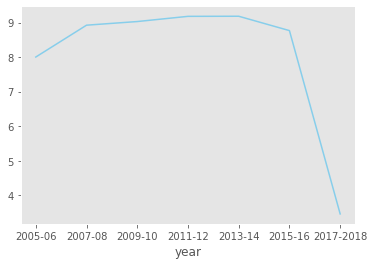

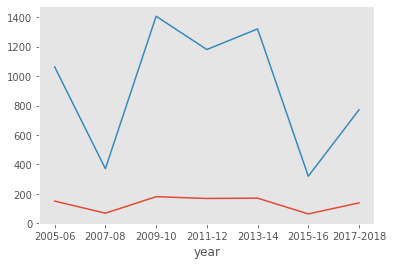

In [ ]:
plt.plot(year, mh_avg, color='skyblue', label= 'Avergae MHI')
plt.grid()
plt.xlabel("year")
plt.show()

plt.plot(year, dead, label = "People who wished to live no longer")
plt.plot(year, dep, label = "Number of people in a state of depression")
plt.xlabel("year")
plt.grid()
plt.show()

Relation b/w unable to get pregnant & feeling bad about yourself.



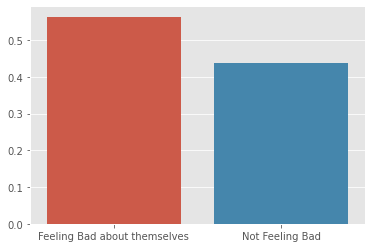

In [ ]:
tmp_df = select_df.drop(select_df.index[select_df["RHQ074"] != 1.0])
y1 = (len(tmp_df[tmp_df["DPQ060"]==1]) + len(tmp_df[tmp_df["DPQ060"]==2]) + len(tmp_df[tmp_df["DPQ060"]==3]))/len(tmp_df)
y2 = 1 - y1
sns.barplot(x=["Feeling Bad about themselves", "Not Feeling Bad"],y=[y1, y2])

More than 50% of women who were unable to get pregnant after trying felt bad about themselves or thought that they were a failure even though it is something not in their control.

Relation between MHI & whether people visited a mental health professional.

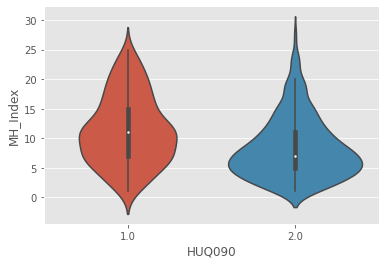

In [ ]:
tmp_df = select_df.drop(select_df.index[select_df["HUQ090"]==9.0])
sns.violinplot(x="HUQ090", y="MH_Index", data=tmp_df)

On average people with a higher MHI visited a mental health professional.